# Wheeled cat-catching robot (i.e., the "catbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `sound` (`True` or `False`) is whether or not to play sounds;
* `number_of_cats` (non-negative integer) is how many cats to launch.

If you want to test your controller with no cats, set `number_of_cats=0`.

In [2]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=None,
    number_of_cats=1,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:
* `camera_sideview()`
* `camera_wideview()`
* `camera_topview()`
* `camera_catview()`

In [3]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

Below is the theory computation and the methods through which K is defined.

In [4]:
import sympy as sym
from scipy import linalg
from scipy.signal import place_poles
from IPython.display import display, Markdown

def get_solution_symbolic(A, B, K, zdot_e, z_e, zdot_i, z_i, thetadot_e, theta_e, thetadot_i, theta_i):

    
    # Model
    A_sym = sym.nsimplify(sym.Matrix(A), rational=True)
    B_sym = sym.nsimplify(sym.Matrix(B), rational=True)
    K_sym = sym.nsimplify(sym.Matrix(K), rational=True)

    # Variables
    t = sym.symbols('t', real=True)

    # Initial condition
    x0 = sym.nsimplify(sym.Matrix([zdot_e - zdot_i, thetadot_e - thetadot_i, z_e - z_i, theta_e - theta_i]), rational=True)

    # Solution
    x_sym = sym.exp((A_sym - B_sym @ K_sym) * t) @ x0

    return x_sym

r_w = 0.325
m_w = 2.4
J_w = 0.12675
r_b = 0.3
m_b = 12.0
J_b = 0.8
g = 9.81

thetaddot, thetadot, theta, zddot, zdot, z, tau = sym.symbols('thetaddot, thetadot, theta, zddot, zdot, z, tau')

M = sym.Matrix([[(J_w / r_w**2) + m_b + m_w, m_b * r_b * sym.cos(theta)],
                [m_b * r_b * sym.cos(theta), J_b + m_b * r_b**2]])
#print(M.inv())

qddot = sym.Matrix([[zddot],[thetaddot]])
N = sym.Matrix([[-m_b*r_b*sym.sin(theta)*thetadot**2],[-g*m_b*r_b*sym.sin(theta)]])
F = sym.Matrix([[1/r_w],[-1]])
R = sym.Matrix([tau])

exp_fur_qddot = M.inv() @ (F @ R - N)
#print(sym.shape(exp_fur_qddot))

xdot = sym.Matrix([[zddot],[thetaddot],[zdot],[thetadot]])
x = sym.Matrix([[zdot],[thetadot],[z],[theta]])

exp_fur_qddot = exp_fur_qddot.row_insert(2, sym.Matrix([zdot]))
exp_fur_qddot = exp_fur_qddot.row_insert(3, sym.Matrix([thetadot]))

#print(sym.shape(exp_fur_qddot))
#print(exp_fur_qddot[2])

#f_num = sym.lambdify([theta, thetadot, zdot, tau], exp_fur_qddot)
#f_num(0,0,0,0)

A = sym.lambdify([theta, thetadot, zdot, tau], exp_fur_qddot.jacobian(x))
A = A(0,0,0,0)
print(A)

B = sym.lambdify([theta, thetadot, zdot, tau], exp_fur_qddot.jacobian(R))
B = B(0,0,0,0)
print(B)
#print(A.lambdify())
#print(B.lambdify())

[[ 0.          0.          0.         -7.76744868]
 [ 0.         -0.          0.         33.65894428]
 [ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]]
[[ 0.57335138]
 [-1.62982179]
 [ 0.        ]
 [ 0.        ]]


Below is specifically the computation for the K matrices.

In [5]:
desired_poles_1 = np.array([-1.2, -1.1, -0.4, -0.7])
desired_poles_2 = np.array([-1.5, -1.4, -1.3, -2.5])
desired_poles_3 = np.array([-1.7, -1.5, -2.0, -4.5])
desired_poles_4 = np.array([-3.0, -1.5, -5.3, -27.5])

place_result1 = place_poles(A, B, desired_poles_1)
K1 = place_result1.gain_matrix

place_result2 = place_poles(A, B, desired_poles_2)
K2 = place_result2.gain_matrix

place_result3 = place_poles(A, B, desired_poles_3)
K3 = place_result3.gain_matrix

#place_result4 = place_poles(A, B, desired_poles_4)
#K4 = place_result4.gain_matrix


print(K1.tolist())
print(K2.tolist())
print(K3.tolist())
#print(K4.tolist())

#print(K2[0][1])

#eigvals = linalg.eigvals(A - B@K1)
#print(eigvals)

[[-0.3157175671084405, -2.197183227183595, -0.055672334352710816, -23.205521178751784]]
[[-2.621690961605975, -5.03315772005845, -1.0280402650368534, -31.05761185794782]]
[[-6.834773190622938, -8.355960580323183, -3.456926605505393, -41.716817317970936]]


In [6]:
'''class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate,
            cat_target,
        ):
        
        # FIXME: replace the following line

        equilibrium_array = np.array([2.5, -2.5, 2, -2, 1.5, -1.5, 1, -1, 0.5, -0.5, 0])
        iteration = t // 6
        #adj_trgt = equilibrium_array[int(iteration)]
        adj_trgt = cat_target
        cruise_speed = 1.25 * np.sign(adj_trgt)
        d_brake1 = 2.5
        d_brake2 = 1
        wheel_torque = (100000*pitch_angle) + (100000*pitch_rate)
        if np.abs(wheel_position - adj_trgt) > d_brake1:
            x_des = np.array([cruise_speed, 
                              0, 
                              wheel_position + (d_brake1 - 0.5) * np.sign(adj_trgt), 
                              0])
            K = K1[0]
            x = np.array([wheel_velocity, pitch_rate, wheel_position, pitch_angle])
            wheel_torque = -K @ (x - x_des)
        elif np.abs(wheel_position - adj_trgt) > d_brake2:
            x_des = np.array([cruise_speed * 0.35, 
                              0, 
                              wheel_position + (d_brake2 - 0.0) * np.sign(adj_trgt), 
                              0])
            K = K2[0]
            x = np.array([wheel_velocity, pitch_rate, wheel_position, pitch_angle])
            wheel_torque = -K @ (x - x_des)
        elif np.abs(wheel_position - adj_trgt) < 0.05:
            wheel_torque = (100000*pitch_angle) + (100000*pitch_rate)
        else:
            x_des = np.array([0, 0, adj_trgt, 0])
            K = K3[0] # - np.array([0, 30, 0, 0])
            x = np.array([wheel_velocity, pitch_rate, wheel_position, pitch_angle])
            wheel_torque = -K @ (x - x_des)
            #wheel_torque = (10000*pitch_angle) + (10000*pitch_rate)

        #x_des = np.array([0, 0, adj_trgt, 0])
        #K = K3[0] # - np.array([0, 30, 0, 0])
        #if (t % 5.9) < 0.5:
        #    if t > 6.0:
        #        K = K3[0] - np.array([0, 10, 0, 0])
        #        x_des[2] = 0
        
        return wheel_torque'''
class Controller:
    def __init__(self):
        # Record the time when the robot first reaches near the target.
        self.target_reached_time = None
    
    def reset(self):
        self.target_reached_time = None
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate,
            cat_target,
        ):
        near_threshold = 0.05  # Define the "near" distance
        
        # Check if we're near the cat target.
        if np.abs(wheel_position - cat_target) < near_threshold:
            if self.target_reached_time is None:
                self.target_reached_time = t  # Start the timer once
            # If we have been near the target for 0.2 second, switch the desired target for deflection.
            if (t - self.target_reached_time) >= 0.2:
                if cat_target > 0:
                    # Target is on the right; Deflect to the left.
                    adj_trgt = cat_target - 1
                    desired_velocity = +0.25
                elif cat_target < 0:
                    # Target is on the left; Deflect to the right.
                    adj_trgt = cat_target + 1
                    desired_velocity = -0.25
                else:
                    adj_trgt = cat_target
                    desired_velocity = 0
                x_des = np.array([desired_velocity, 0, adj_trgt, 0])
                K = K3[0]  # Use our K3 gain for this near-target low-speed behavior.
                x = np.array([wheel_velocity, pitch_rate, wheel_position, pitch_angle])
                wheel_torque = -K @ (x - x_des)
                return wheel_torque
        else:
            # If we're not near the target, reset the timer.
            self.target_reached_time = None

        # Control logic
        equilibrium_array = np.array([2.5, -2.5, 2, -2, 1.5, -1.5, 1, -1, 0.5, -0.5, 0])
        iteration = t // 6
        adj_trgt = cat_target
        if np.abs(adj_trgt) <= 1:
            cruise_speed = 1.2 * np.sign(adj_trgt)
            #print('1')
        elif np.abs(adj_trgt) <= 2.5:
            cruise_speed = 1.525 * np.sign(adj_trgt)
            #print('2')
        else:
            cruise_speed = 1.61 * np.sign(adj_trgt)
            #print('3')
        d_brake1 = 2.5
        d_brake2 = 1
        
        if np.abs(wheel_position - adj_trgt) > d_brake1:
            x_des = np.array([
                cruise_speed, 
                0, 
                wheel_position + (d_brake1 - 0.5) * np.sign(adj_trgt), 
                0
            ])
            K = K1[0]
        elif np.abs(wheel_position - adj_trgt) > d_brake2:
            x_des = np.array([
                cruise_speed * 0.35, 
                0, 
                wheel_position + (d_brake2) * np.sign(adj_trgt), 
                0
            ])
            K = K2[0]
        else:
            x_des = np.array([0, 0, adj_trgt, 0])
            K = K3[0]
        
        x = np.array([wheel_velocity, pitch_rate, wheel_position, pitch_angle])
        wheel_torque = -K @ (x - x_des)
        
        return wheel_torque



Create an instance of the controller.

Reset the simulator with given initial conditions.

In [7]:
controller = Controller()

simulator.reset(
    initial_wheel_position=0.,
    initial_wheel_velocity=0.,
    initial_pitch_angle=0.,
    initial_pitch_rate=0.,
)

controller.reset()

In [8]:

data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=8.99,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename='my_video.mov',  # <-- optional (save video to this file, e.g., 'my_video.mov')
)
number_of_cats_saved = simulator.get_number_of_cats_saved()
'''arrayofsaved = []
arrayofsaved.append(number_of_cats_saved)

index = 1
while index < 100:
    data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=8.99,    # <-- optional (how long you want to run the simulation in seconds)
    )
    print('Cat Saved:')
    print(simulator.get_number_of_cats_saved())
    arrayofsaved.append(simulator.get_number_of_cats_saved())
    index+=1

print('Total Cats Saved:')
print(sum(arrayofsaved))'''
print(number_of_cats_saved)

1


Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

Count the number of saved cats.

Get, show, and save a snapshot of the simulation after the last time step.

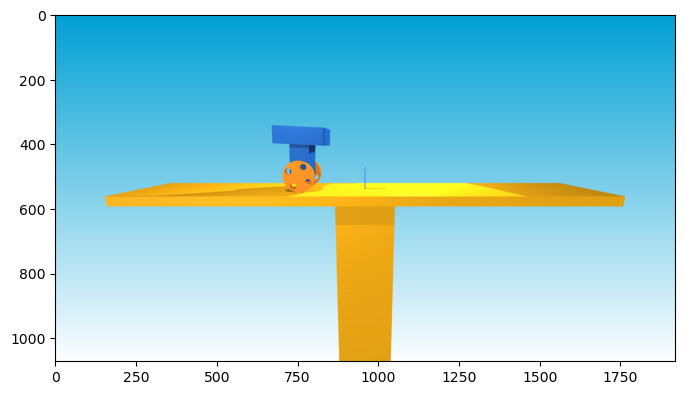

In [9]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

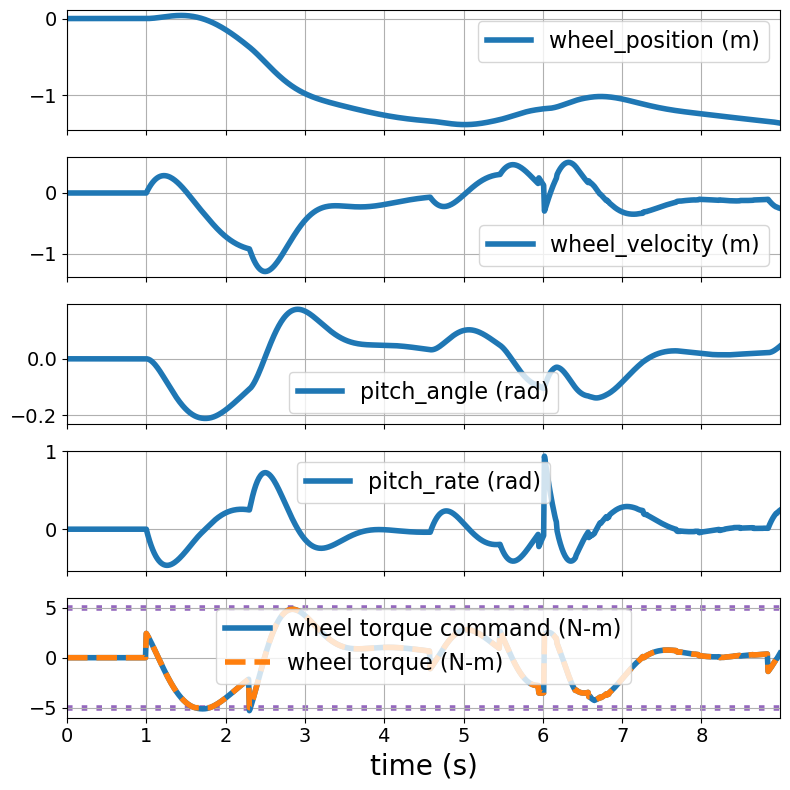

In [10]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_wheel_position,
    ax_wheel_velocity,
    ax_pitch_angle,
    ax_pitch_rate,
    ax_wheel_torque,
) = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

# Plot wheel position
ax_wheel_position.plot(
    data['t'], data['wheel_position'],
    label='wheel_position (m)', linewidth=4,
)
ax_wheel_position.grid()
ax_wheel_position.legend(fontsize=16)
ax_wheel_position.tick_params(labelsize=14)

# Plot wheel velocity
ax_wheel_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel_velocity (m)', linewidth=4,
)
ax_wheel_velocity.grid()
ax_wheel_velocity.legend(fontsize=16)
ax_wheel_velocity.tick_params(labelsize=14)

# Plot pitch angle
ax_pitch_angle.plot(
    data['t'], data['pitch_angle'],
    label='pitch_angle (rad)', linewidth=4,
)
ax_pitch_angle.grid()
ax_pitch_angle.legend(fontsize=16)
ax_pitch_angle.tick_params(labelsize=14)

# Plot pitch rate
ax_pitch_rate.plot(
    data['t'], data['pitch_rate'],
    label='pitch_rate (rad)', linewidth=4,
)
ax_pitch_rate.grid()
ax_pitch_rate.legend(fontsize=16)
ax_pitch_rate.tick_params(labelsize=14)

# Plot wheel torque
ax_wheel_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.grid()
ax_wheel_torque.legend(fontsize=16)
ax_wheel_torque.tick_params(labelsize=14)
ax_wheel_torque.set_ylim(
    -1.2 * simulator.maximum_wheel_torque,
    1.2 * simulator.maximum_wheel_torque,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_wheel_torque.set_xlabel('time (s)', fontsize=20)
ax_wheel_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()


Save the figure (without transparent background).

In [11]:
fig.savefig('equilibrium_figure.png', facecolor='white', transparent=False)